Hanna Olsson 

Johan Östling

# Imports


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer

# Exercise question

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print(accuracy_score(Y1, guesses1))

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
#classifier2 = make_pipeline(DictVectorizer(), LinearSVC())
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print(accuracy_score(Y2, guesses2))

1.0
0.5


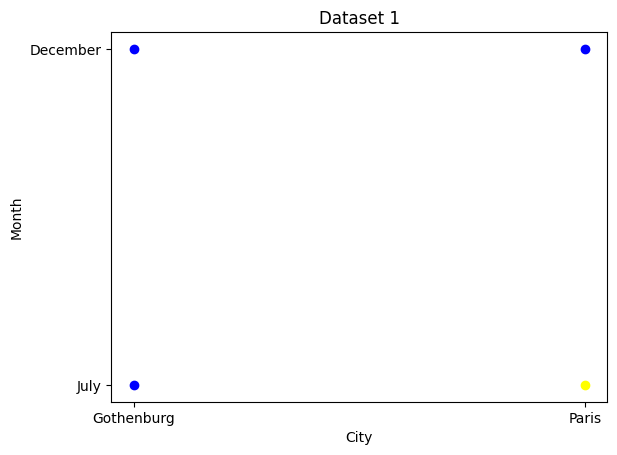

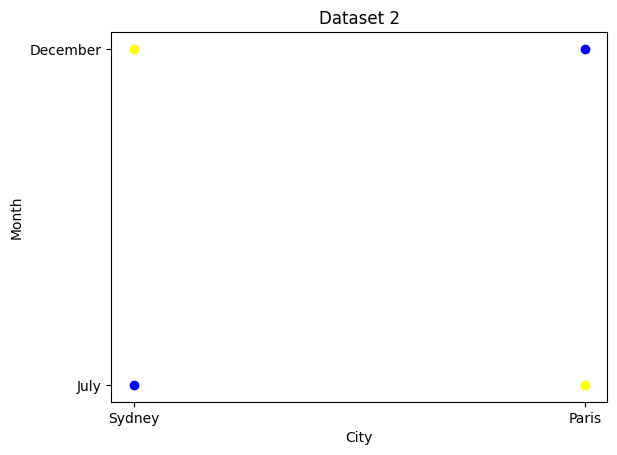

In [ ]:
import matplotlib.pyplot as plt

# Create a dictionary that maps weather strings to colors
colors = {'rain': 'blue', 'sun': 'yellow'}

# Create the scatter plot for the first dataset
fig, ax = plt.subplots()
for i in range(len(X1)):
    if Y1[i] == 'rain':
        ax.scatter(X1[i]['city'], X1[i]['month'], c=colors['rain'], label='rain')
    else:
        ax.scatter(X1[i]['city'], X1[i]['month'], c=colors['sun'], label='sun')
plt.xlabel('City')
plt.ylabel('Month')
plt.title('Dataset 1')

# Display the first plot
plt.show()

# Create the scatter plot for the second dataset
fig, ax = plt.subplots()
for i in range(len(X2)):
    if Y2[i] == 'rain':
        ax.scatter(X2[i]['city'], X2[i]['month'], c=colors['rain'], label='rain')
    else:
        ax.scatter(X2[i]['city'], X2[i]['month'], c=colors['sun'], label='sun')
plt.xlabel('City')
plt.ylabel('Month')
plt.title('Dataset 2')

# Display the second plot
plt.show()


For a linear classifier we can see from the plots that it is not possible to draw a line to seperate the labels for the second training set. While in the first it is. We also identified for the second training set that it could be resembled with an XOR gate and this is known to not be linearly seperable. 

#Introduction

In [ ]:

"""This file shows a couple of implementations of the perceptron learning
algorithm. It is based on the code from Lecture 3, but using the slightly
more compact perceptron formulation that we saw in Lecture 6.

There are two versions: Perceptron, which uses normal NumPy vectors and
matrices, and SparsePerceptron, which uses sparse vectors and matrices.
The latter may be faster when we have high-dimensional feature representations
with a lot of zeros, such as when we are using a "bag of words" representation
of documents.
"""

import numpy as np
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


class Perceptron(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # Perceptron algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):

                # Compute the output score for this instance.
                score = x.dot(self.w)

                # If there was an error, update the weights.
                if y*score <= 0:
                    self.w += y*x


##### The following part is for the optional task.

### Sparse and dense vectors don't collaborate very well in NumPy/SciPy.
### Here are two utility functions that help us carry out some vector
### operations that we'll need.

def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return np.dot(w[x.indices], x.data)


class SparsePerceptron(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        for i in range(self.n_iter):
            for x, y in XY:

                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)

                # If there was an error, update the weights.
                if y*score <= 0:
                    # (This corresponds to self.w += y*x above.)
                    add_sparse_to_dense(x, self.w, y)





In [11]:
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#from aml_perceptron import Perceptron, SparsePerceptron

# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y


if __name__ == '__main__':
    
    # Read all the documents.
    X, Y = read_data('all_sentiment_shuffled.txt')
    
    # Split into training and test parts.
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)

    # Set up the preprocessing steps and the classifier.
    pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),

        # NB that this is our Perceptron, not sklearn.linear_model.Perceptron
        Perceptron()  
    )

    # Train the classifier.
    t0 = time.time()
    pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    print('Training time: {:.2f} sec.'.format(t1-t0))

    # Evaluate on the test set.
    Yguess = pipeline.predict(Xtest)
    print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 2.37 sec.
Accuracy: 0.7919.


#Implementing the SCV

In [38]:
import random
class SVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=100):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """
        #w = np.zeros(len(X))
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        lamb = 1/X.shape[0]
        self.w = np.zeros(n_features)
        t = 0
        # Pegasus algorithm:
        for i in range(self.n_iter):
           for x, y in zip(X, Ye):
                t = t+1
                n = 1/(lamb*t)
                # Compute the output score for this instance.
                score = x.dot(self.w)

                # If there was an error, update the weights.
                if y*score < 1:
                    self.w = (1-n*lamb)*self.w + n*y*x
                else:
                    self.w = (1-n*lamb)*self.w

In [39]:
# Read all the documents.
X, Y = read_data('all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),

    # NB that this is our Perceptron, not sklearn.linear_model.Perceptron
    SVC()  
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 13.16 sec.
Accuracy: 0.8368.


# Logistic Regression 

In [40]:
class LR(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=100):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """
        #w = np.zeros(len(X))
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        lamb = 1/X.shape[0]
        self.w = np.zeros(n_features)
        t = 0
        # Pegasus algorithm:
        for i in range(self.n_iter):
           for x, y in zip(X, Ye):
                t = t+1
                n = 1/(lamb*t)
                # Compute the output score for this instance.
                score = x.dot(self.w)

                # Update the weights.
                self.w = (1-n*lamb)*self.w + n*(y*x/(1 + np.exp(y*score)))

In [41]:
# Read all the documents.
X, Y = read_data('all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),

    # NB that this is our Perceptron, not sklearn.linear_model.Perceptron
    LR()  
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 23.46 sec.
Accuracy: 0.8380.


We can see that it performs very similar to the SVC in terms of accuracy. However, there is a difference in training time as the logistic regression classifier takes a few seconds longer in general. This can be because SVC is better at handling sparse data (like text) which makes the algorithm run faster. 

# Bonus task 1. Making your code more efficient

**a) Faster linear algebra operations** 

In [44]:
import scipy.linalg as la
import random
class SVC_fast(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=100):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """
        #w = np.zeros(len(X))
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        lamb = 1/X.shape[0]
        self.w = np.zeros(n_features)
        t = 0
        # Pegasus algorithm:
        for i in range(self.n_iter):
           for x, y in zip(X, Ye):
                t = t+1
                n = 1/(lamb*t)
                # Compute the output score for this instance.
                score = la.blas.ddot(x,self.w)

                # If there was an error, update the weights.
                if y*score < 1:
                    la.blas.dscal((1-n*lamb),self.w)
                    la.blas.daxpy(x,self.w,a=n*y)
                else:
                    la.blas.dscal((1-n*lamb),self.w)




In [45]:
# Read all the documents.
X, Y = read_data('all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),

    # NB that this is our Perceptron, not sklearn.linear_model.Perceptron
    SVC_fast()  
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 10.81 sec.
Accuracy: 0.8368.


**b) Using sparse vectors**

In [49]:
class SVC_sparse(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=100):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """
        #w = np.zeros(len(X))
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        lamb = 1/X.shape[0]
        self.w = np.zeros(n_features)
        t = 0
        # Pegasus algorithm:
        for i in range(self.n_iter):
           for x, y in zip(X, Ye):
                t = t+1
                n = 1/(lamb*t)
                # Compute the output score for this instance.
                score = sparse_dense_dot(x,self.w)

                # If there was an error, update the weights.
                if y*score < 1:
                    la.blas.dscal((1-n*lamb),self.w)
                    add_sparse_to_dense(x,self.w,n*y)
                else:
                    la.blas.dscal((1-n*lamb),self.w)


In [51]:
# Read all the documents.
X, Y = read_data('all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),

    SVC_sparse()  
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 111.20 sec.
Accuracy: 0.8418.


**c) Speeding up the scaling operation**